
<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />

## Deep Learning with RNNs

This notebook shows three commonly used neural network architectures to detect malicious URLs using **RNNs**. 

The task is to build a model that will be able to classify a URL as *malicious* or *benign*. 

Libraries:
- [Keras](https://keras.io/) is used as high-level API for [tensorflow](https://www.tensorflow.org/) backend
- [string.printable](https://docs.python.org/3/library/string.html#string.printable) returns the text string. That is, it returns the printable symbols. The result obtained is equivalent to the concatenation of those returned by string.digits , string.ascii_letters , string.punctuation and string.whitespace.
- pandas
- numpy
- json

In [61]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
import re, os
from string import printable
from sklearn import model_selection

#import gensim
import tensorflow as tf
import keras

import warnings
warnings.filterwarnings("ignore")

In [63]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## Load raw URL data

In [4]:
## Load data URL

DATA_HOME = '../data/'
df = pd.read_csv(DATA_HOME + 'url_data_mega_deep_learning.csv')
df.sample(n=25).head(5) 

,url,isMalicious
135648,amarhost.info/images/start4.php,1
112752,wugin.com/user/ids,1
82922,tweaktown.com/cat/storage/drive-docking-statio...,0
30529,djtechtools.com/product_categories/2,0
37430,pedaily.cn/u/lixing/201604131324300.shtml,0


## Pre-processing URL data
**Step 1**: Convert each raw URL string to integers. 

For a given string, if the characters that are contained in **printable**, they can be assigned a number (encoded) using the **printable.index()** 


In [9]:
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in df.url]

# print out a few of these encoded characters
url_int_tokens[0][0:10]

[29, 25, 24, 17, 22, 35, 28, 19, 13, 29]

**Step 2:** Cut URL string at max_len or pad with zeros if shorter. 

Because, we need for the inputs into a neural network to all be the same length.

Use the keras.preprocessing.pad_sequence method for this task

In [10]:
max_len=75
X = keras.preprocessing.sequence.pad_sequences(url_int_tokens, maxlen=max_len)

**Step 3:** Extract labels from the pandas dataframe and convert to a numpy array|

In [17]:
targets = np.array(df.isMalicious)

print('Dimensions of Features: ', X.shape,'\nDimensions of Targets: ', targets.shape)

Dimensions of Features:  (194798, 75) 
Dimensions of Targets:  (194798,)


## Test/Train Split

In [100]:
split_ratios = (0.7, 0.15, 0.15)  # Training, Validation, Test


X_train, X_temp, y_train, y_temp = model_selection.train_test_split(X, targets, test_size=(1 - split_ratios[0]), stratify=targets, random_state=42)
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_temp, y_temp, stratify=y_temp, test_size=split_ratios[2] / (split_ratios[1] + split_ratios[2]), random_state=42)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)
y_val.shape

(29220, 2)

In [91]:
X_val.shape

(29220, 75)

## Architecture for an LSTM

In [79]:
model_name = 'lstm_URL_Classifier'

In [119]:
final_dense_units = 2
max_len=75
emb_dim=32
max_vocab_len=100
lstm_output_size=32
#W_regularizer=keras.regularizers.l2(1e-4)

lstm_model = keras.Sequential(name=model_name)

lstm_model.add(keras.layers.Input(shape=(max_len,), dtype='int32'))
lstm_model.add(keras.layers.Embedding(input_dim=max_vocab_len, output_dim=emb_dim))#, input_shape=(max_len,)))#, input_length=max_len))
lstm_model.add(keras.layers.LSTM(lstm_output_size))
lstm_model.add(keras.layers.Dropout(0.5))
lstm_model.add(keras.layers.Dense(final_dense_units, activation='sigmoid'))

lstm_optimizer = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

lstm_model.compile(optimizer=lstm_optimizer,  
                   loss='binary_crossentropy', 
                   metrics=['accuracy'] 
                  # metrics=keras.metrics.F1Score(threshold=0.5)]
                  )
lstm_model.summary()

Model: "lstm_URL_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)             │ (None, 75, 32)              │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,586 (45.26 KB)

 Trainable params: 11,586 (45.26 KB)

 Non-trainable params: 0 (0.00 B)

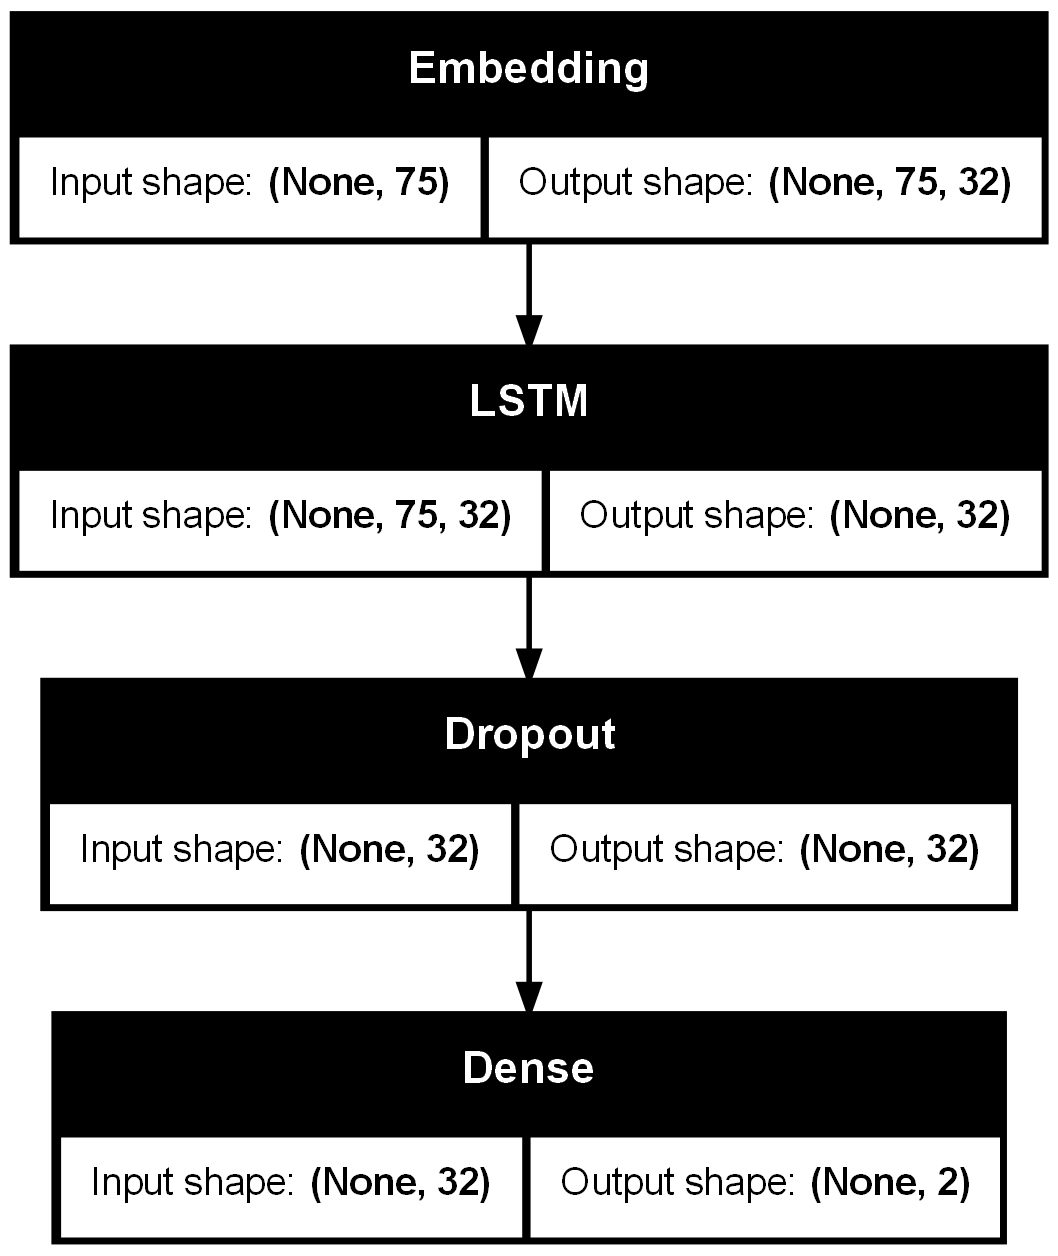

In [120]:
keras.utils.plot_model(lstm_model, show_shapes=True)#   , to_file='./model0.png')

## Train Model

In [121]:
nb_epoch = 3
batch_size = 32

CallBack = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1),
        keras.callbacks.TensorBoard(log_dir="./log_dir/"+ model_name, histogram_freq=1)]

lstm_model.fit(X_train, 
               y_train, 
               epochs=nb_epoch,
               batch_size=batch_size,
              validation_data = (X_val, y_val),
               verbose = 1, 
               callbacks= CallBack
              )

Epoch 1/3
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 319s 62ms/step - accuracy: 0.7220 - loss: 0.5510 - val_accuracy: 0.8260 - val_loss: 0.3962
Epoch 2/3
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 310s 59ms/step - accuracy: 0.8261 - loss: 0.4036 - val_accuracy: 0.8358 - val_loss: 0.3762
Epoch 3/3
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - accuracy: 0.8362 - loss: 0.3829 - val_accuracy: 0.8445 - val_loss: 0.3574


In [122]:
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=1)

print('\nFinal Cross-Validation Accuracy', accuracy, '\n')

914/914 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.8440 - loss: 0.3578

Final Cross-Validation Accuracy 0.8437029719352722 



In [124]:
lstm_model.save("lstm_URL_Classifier.keras")

In [125]:

# Launch TensorBoard
# Supervising the SubjectIDClassifier model
%tensorboard --logdir './log_dir/lstm_URL_Classifier'

Reusing TensorBoard on port 6008 (pid 49460), started 0:49:42 ago. (Use '!kill 49460' to kill it.)

## Making a prediction

In [142]:
test_url_mal = "naureen.net/etisalat.ae/index2.php"
test_url_benign = "sixt.com/php/reservation?language=en_US"

url = test_url_mal

In [143]:
# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer 
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable]]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=75
processed_url = keras.preprocessing.sequence.pad_sequences(url_int_tokens, maxlen=max_len)

In [147]:
target_proba = lstm_model.predict(processed_url, batch_size=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


In [153]:
def threshold_result(proba):
    if proba > 0.5:
        return "MALICIOUS!"
    else:
        return "benign"

In [154]:
print("Test URL:\n", url, "\nis", threshold_result(target_proba[0][1]))

Test URL:
 naureen.net/etisalat.ae/index2.php 
is MALICIOUS
